In [32]:
# All imported libraries
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import xml.etree.ElementTree as ET
from PIL import Image
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Input
from keras import Model
from keras import optimizers
from keras.models import Sequential
# from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
import time
import math

## Loading data
This function loads all data into their own numpy arrays.

In [33]:
# Function that loads all required data in its own np array.
def load_and_preprocess_dataset():
    x_train = []
    y_train = []
    data = os.listdir('CarsSet/DATA/DATA/train')
    imgShape = None
    for image in data:
        if(image.endswith('.jpg')):
            # Load the image
            img = cv2.imread(os.path.join('CarsSet/DATA/DATA/train', image))
            imgShape = img
            # Resize the image to 224x224
            img = cv2.resize(img, (224, 224))
            x_train.append(img)
        else:
            # Load the XML annotation file
            tree = ET.parse(os.path.join('CarsSet/DATA/DATA/train', image))
            root = tree.getroot()
            bndbox = root.find('.//bndbox')
            bbox = []
            # Extract the xmin, ymin, xmax, and ymax values from the bndbox element
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            # Scale the bounding box coordinates to match the resized image
            height, width, _ = imgShape.shape
            scale_x = 224 / width
            scale_y = 224 / height
            xmin = int(xmin * scale_x)
            ymin = int(ymin * scale_y)
            xmax = int(xmax * scale_x)
            ymax = int(ymax * scale_y)
            bbox.append(xmin)
            bbox.append(ymin)
            bbox.append(xmax)
            bbox.append(ymax)
            y_train.append(bbox)
    
    
    x_val = []
    y_val = []
    data = os.listdir('CarsSet/DATA/DATA/validate')
    imgShape = None
    for image in data:
        if(image.endswith('.jpg')):
            # Load the image
            img = cv2.imread(os.path.join('CarsSet/DATA/DATA/validate', image))
            imgShape = img
            # Resize the image to 224x224
            img = cv2.resize(img, (224, 224))
            x_val.append(img)
        else:
            # Load the XML annotation file
            tree = ET.parse(os.path.join('CarsSet/DATA/DATA/validate', image))
            root = tree.getroot()
            bndbox = root.find('.//bndbox')
            bbox = []
            # Extract the xmin, ymin, xmax, and ymax values from the bndbox element
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            # Scale the bounding box coordinates to match the resized image
            height, width, _ = imgShape.shape
            scale_x = 224 / width
            scale_y = 224 / height
            xmin = int(xmin * scale_x)
            ymin = int(ymin * scale_y)
            xmax = int(xmax * scale_x)
            ymax = int(ymax * scale_y)
            bbox.append(xmin)
            bbox.append(ymin)
            bbox.append(xmax)
            bbox.append(ymax)
            y_val.append(bbox)


    x_test = []
    y_test = []
    data = os.listdir('CarsSet/DATA/DATA/test')
    imgShape = None
    for image in data:
        if(image.endswith('.jpg')):
            # Load the image
            img = cv2.imread(os.path.join('CarsSet/DATA/DATA/test', image))
            imgShape = img
            # Resize the image to 224x224
            img = cv2.resize(img, (224, 224))
            x_test.append(img)
        else:
            # Load the XML annotation file
            tree = ET.parse(os.path.join('CarsSet/DATA/DATA/test', image))
            root = tree.getroot()
            bndbox = root.find('.//bndbox')
            bbox = []
            # Extract the xmin, ymin, xmax, and ymax values from the bndbox element
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            # Scale the bounding box coordinates to match the resized image
            height, width, _ = imgShape.shape
            scale_x = 224 / width
            scale_y = 224 / height
            xmin = int(xmin * scale_x)
            ymin = int(ymin * scale_y)
            xmax = int(xmax * scale_x)
            ymax = int(ymax * scale_y)
            bbox.append(xmin)
            bbox.append(ymin)
            bbox.append(xmax)
            bbox.append(ymax)
            y_test.append(bbox)
            
    x_multi = []
    data = os.listdir('CarsSet/DATA/DATA/multiple_experiment')
    imgShape = None
    for image in data:
        if(image.endswith('.jpg')):
            # Load the image
            img = cv2.imread(os.path.join('CarsSet/DATA/DATA/multiple_experiment', image))
            imgShape = img
            # Resize the image to 224x224
            img = cv2.resize(img, (224, 224))
            x_multi.append(img)

    x_above = []
    data = os.listdir('CarsSet/DATA/DATA/above_experiment')
    imgShape = None
    for image in data:
        if(image.endswith('.jpg')):
            # Load the image
            img = cv2.imread(os.path.join('CarsSet/DATA/DATA/above_experiment', image))
            imgShape = img
            # Resize the image to 224x224
            img = cv2.resize(img, (224, 224))
            x_above.append(img)

    return np.array(x_train), np.array(y_train), np.array(x_val), np.array(y_val), np.array(x_test), np.array(y_test), np.array(x_multi), np.array(x_above)


In [34]:
# Load and preprocess the dataset
X_train, Y_train, X_val, Y_val, X_test, Y_test, X_multi, X_above = load_and_preprocess_dataset()

## Neural network using Sequential model
This model has several convolutional layers followed by max pooling layers to extract features from the input images. The feature maps are then flattened and fed into a dense layer. The output layer has 4 units corresponding to the coordinates of the bounding box (x1, y1, x2, y2) for car detection.

In [35]:
# Define the sequential model
model1 = Sequential()

# Get the input shape from X_train
input_shape = X_train.shape[1:]

# Set the input shape
model1.add(Input(shape=input_shape))

# Add convolutional layers
model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(128, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))
model1.add(Conv2D(256, (3, 3), activation='relu'))
model1.add(MaxPooling2D((2, 2)))

# Flatten the feature maps
model1.add(Flatten())

# Add a dense layer
model1.add(Dense(256, activation='relu'))

# Output layer for bounding box regression
model1.add(Dense(4, activation='linear'))

# Compile the model
model1.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │     9,437,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,826,884 (37.49 MB)

 Trainable params: 9,826,884 (37.49 MB)

 Non-trainable params: 0 (0.00 B)

## Neural network using pretrained VGG16
In the following code I make a model based on the VGG16 model from Keras. For detecting cars in images, the VGG16 model can be fine-tuned on a dataset of car images, where the last fully connected layer is replaced with a new output layer that predicts the bounding box coordinates of the car in the image. The pre-trained weights of the model can then be fine-tuned on this new task, which allows the model to learn to detect cars in images with high accuracy.

To fine-tune the VGG16 model I dont include the top classification layer and make it myself. 
These lines add a flatten layer and a dense layer on top of the pre-trained VGG16 model. The Flatten layer flattens the output from the previous layer to a 1D tensor. The first Dense layer has 256 units with a ReLU activation function. The final Dense layer has 4 units with a linear activation function.

In [36]:
# Get the input shape from X_train
input_shape = X_train.shape[1:]

# Load VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Add a flatten layer and a dense layer for classification
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
output = Dense(4, activation='linear')(x)

# Create a new model with input and output layers, so that only the weights of the new top classification layer will be updated during training.
model2 = Model(inputs=base_model.input, outputs=output)

# Freeze the weights of the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model2.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

model2.summary()


Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

# Add a HUE filter
Checken of de image monochroom is. of misschien RGB of HSV beter werkt. Vooral HUE gebruiken tip van Marius.

# Add more training by moving images over
Meer training krijgen door plaatje een stuk op te schuiven. Naam hiervoor opzoeken. Ook controleren hoe de convolution werkt.

# Add dropout layers
Dropout layer toevoegen voor de flatten en misschien voor de conv layers. De loss moet ongeveer gelijk zijn. Tussen test en val data.

## Training the Models
The models are being trained below, I am using 10 epochs because it does not find much improvement after that.

In [37]:
# Train the model
hist1 = model1.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val), batch_size=32)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 418ms/step - loss: 187221.0312 - val_loss: 1034.7323
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 449ms/step - loss: 5133.6914 - val_loss: 1026.8484
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 405ms/step - loss: 1512.3243 - val_loss: 926.2015
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 393ms/step - loss: 1044.1473 - val_loss: 799.4516
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 389ms/step - loss: 880.7164 - val_loss: 731.8193
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step - loss: 871.6671 - val_loss: 679.5629
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 383ms/step - loss: 735.7579 - val_loss: 653.3952
Epoch 8/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 386ms/step - loss: 659.6440 - val_loss: 602.2897
Epoch 9/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 393ms/step - loss: 615.0919 - val_loss: 605.4775
Epoch 10/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 384ms/step - loss: 568.5481 - val_loss: 551.8414


In [38]:
# Train the model
hist2 = model2.fit(X_train, Y_train, epochs=10, validation_data=(X_val, Y_val), batch_size=32)

Epoch 1/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 15044.5000 - mean_squared_error: 15044.5000 - val_loss: 2210.9646 - val_mean_squared_error: 2210.9646
Epoch 2/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 3992.1279 - mean_squared_error: 3992.1279 - val_loss: 1475.2062 - val_mean_squared_error: 1475.2062
Epoch 3/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 1809.4990 - mean_squared_error: 1809.4990 - val_loss: 1447.2628 - val_mean_squared_error: 1447.2628
Epoch 4/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 1019.1996 - mean_squared_error: 1019.1996 - val_loss: 689.2754 - val_mean_squared_error: 689.2754
Epoch 5/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 489.8398 - mean_squared_error: 489.8398 - val_loss: 810.8069 - val_mean_squared_error: 810.8069
Epoch 6/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - loss: 252.7504 - mean_squared_error: 252.7504 - val_loss: 504.7027 - val_mean_squared_error: 504.7027
Epoch 7/10
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - loss: 194.1233 - mean_

## Results training
Below are the results of training the model. As can be seen in the histogram, the algorithm quickly improves in recognizing cars. This is also evident in the orange line, which validates this.

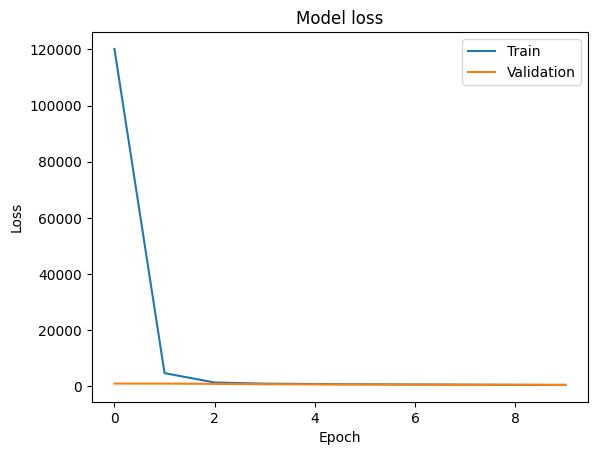

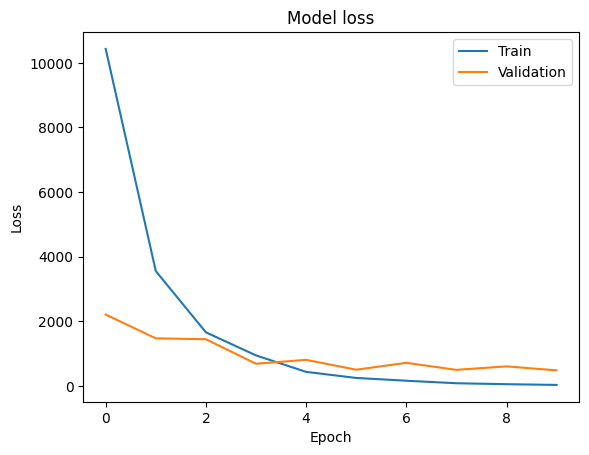

In [39]:
# Plot training & validation loss values
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation loss values
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## Results
As can be seen in the images, both models can usually extract the car from the image. The bounding box is not always perfectly around the car, but it usually identifies the headlights. It sometimes struggles with clouds and mountains, where the models can be almost completely wrong. 

On average the Sequential is about 28.5 off and the VGG16 is about 21 so the VGG16 works better.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
0.40621232986450195  seconds to predict bounding boxes.


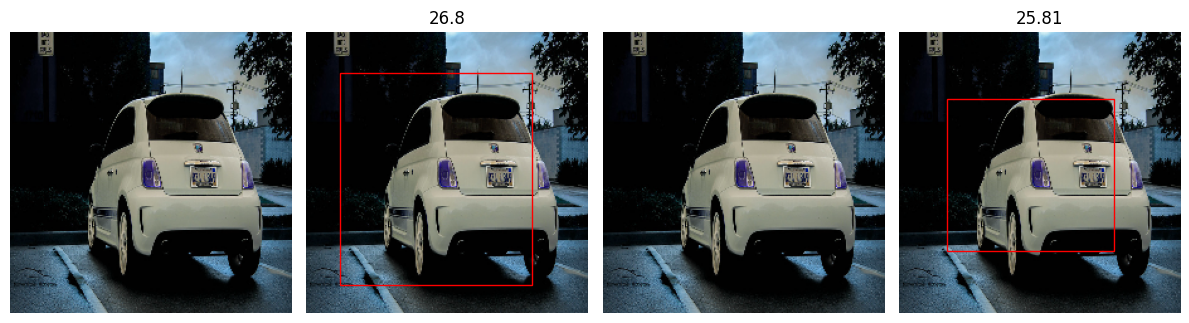

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
0.22662830352783203  seconds to predict bounding boxes.


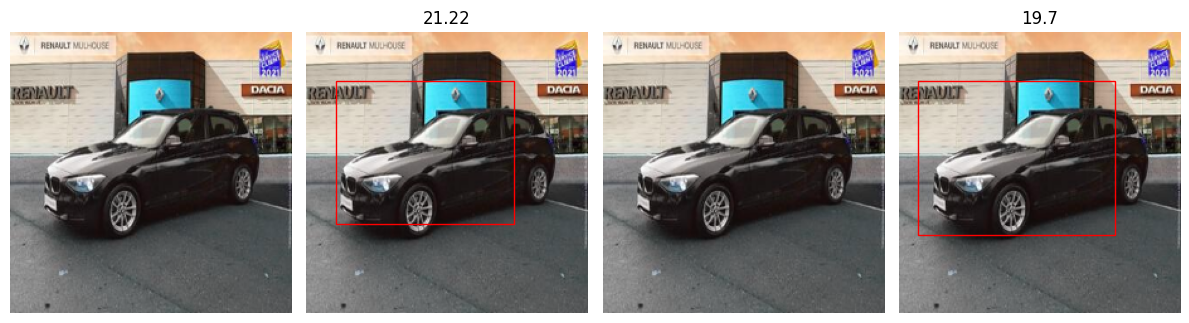

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
0.22440028190612793  seconds to predict bounding boxes.


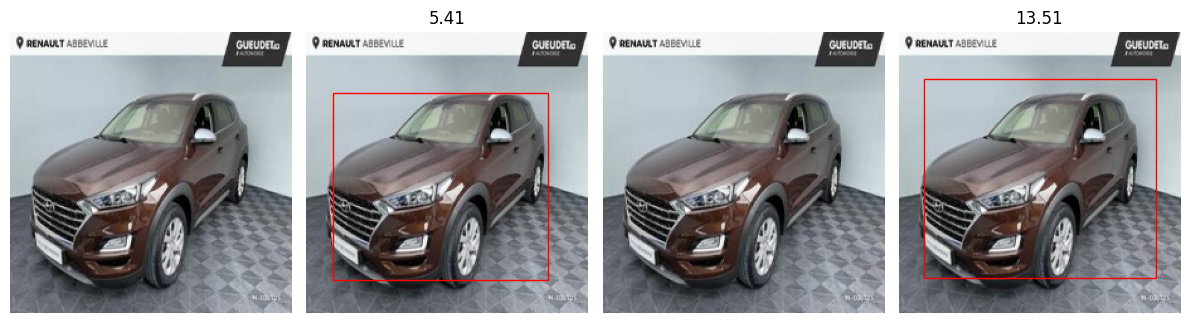

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
0.2259063720703125  seconds to predict bounding boxes.


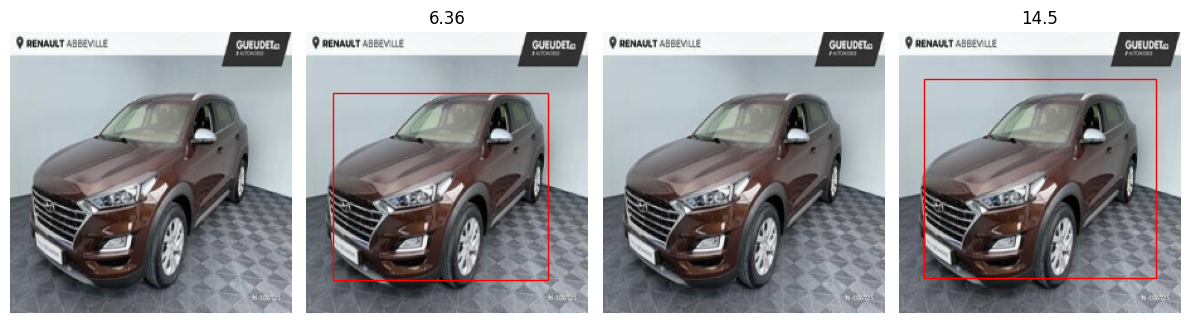

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
0.24421143531799316  seconds to predict bounding boxes.


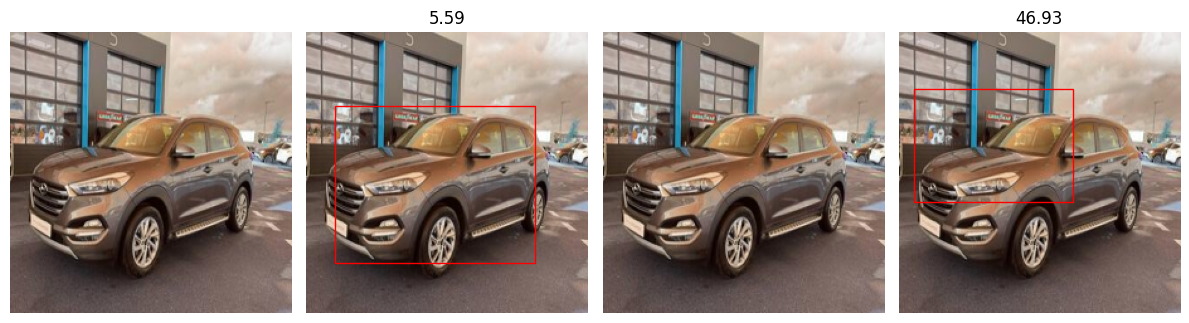

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
0.20929527282714844  seconds to predict bounding boxes.


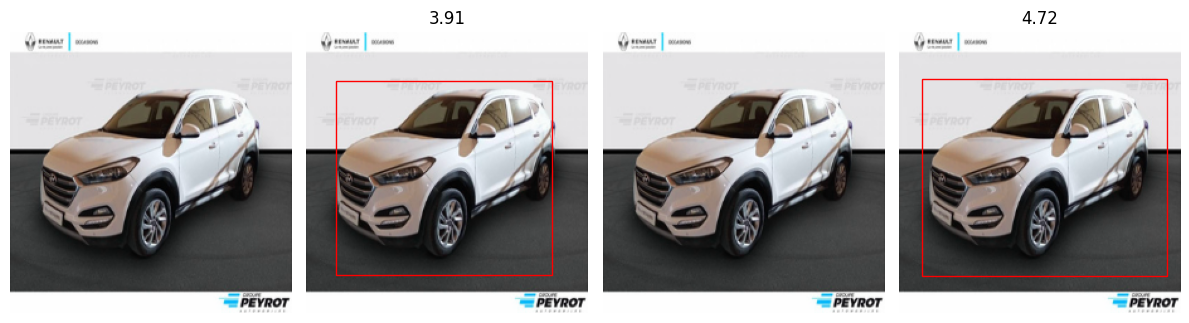

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
0.20272612571716309  seconds to predict bounding boxes.


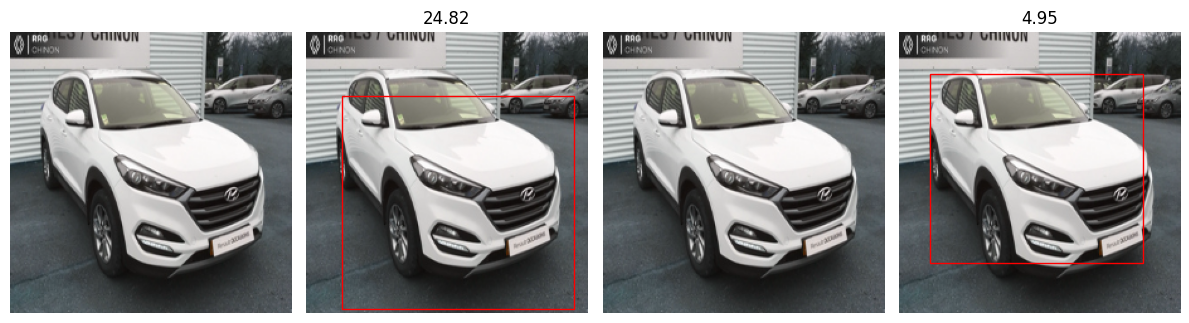

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
0.2188282012939453  seconds to predict bounding boxes.


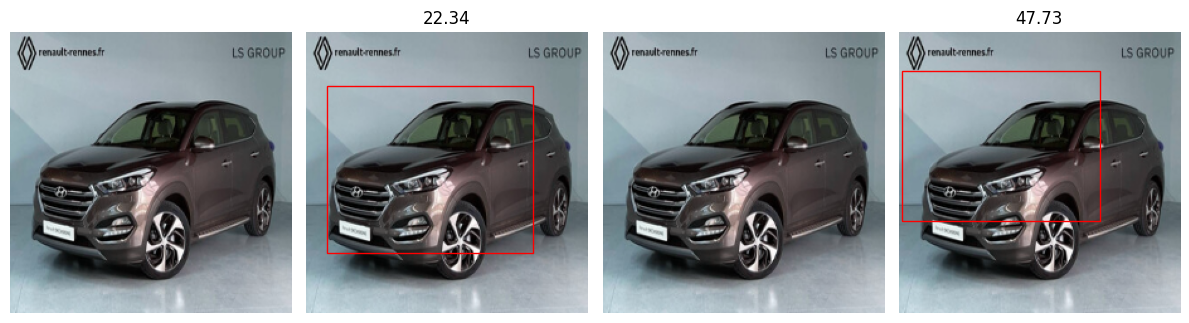

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
0.20469951629638672  seconds to predict bounding boxes.


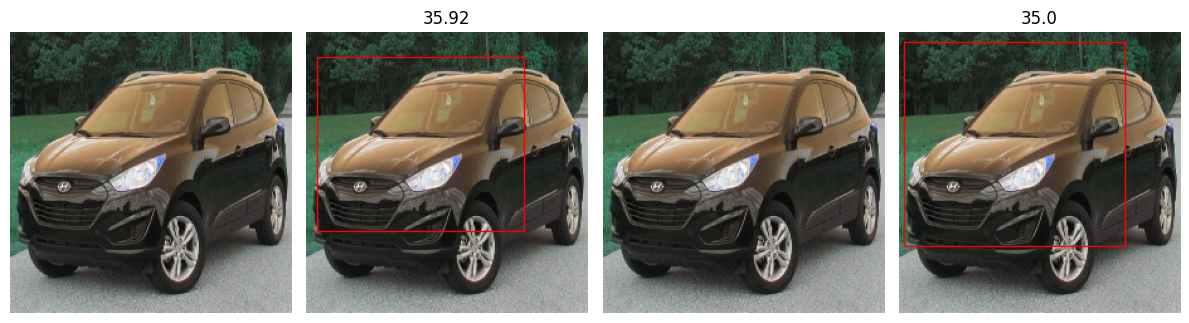

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
0.21947097778320312  seconds to predict bounding boxes.


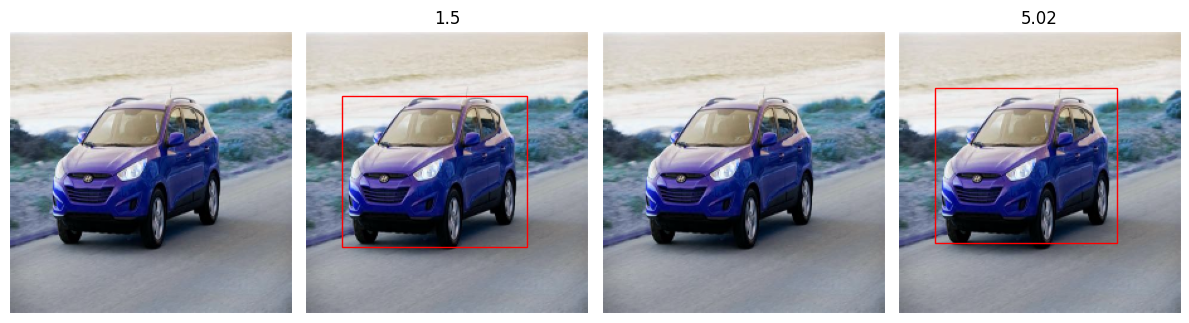

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
0.22105026245117188  seconds to predict bounding boxes.


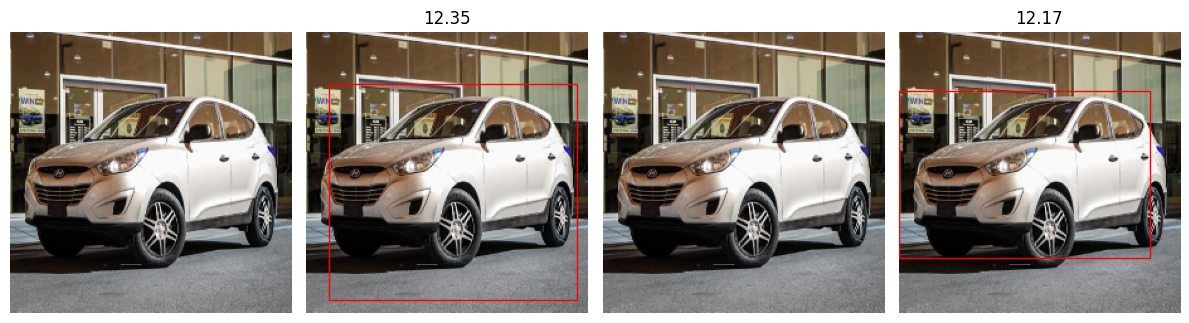

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
0.20519375801086426  seconds to predict bounding boxes.


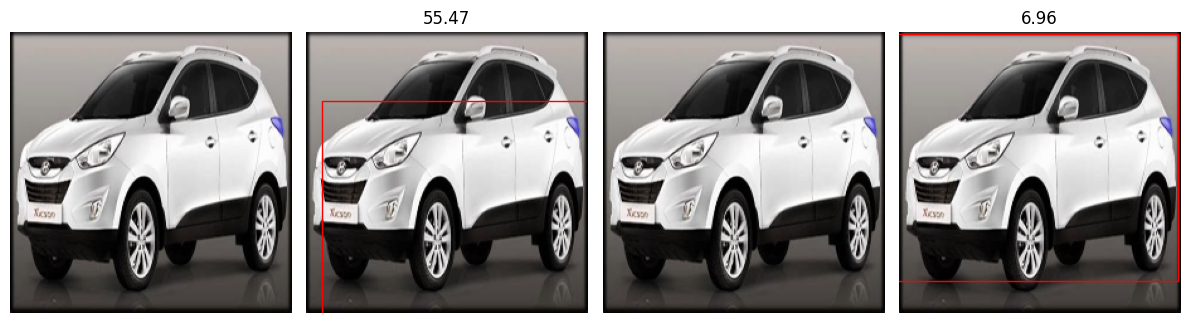

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
0.20390939712524414  seconds to predict bounding boxes.


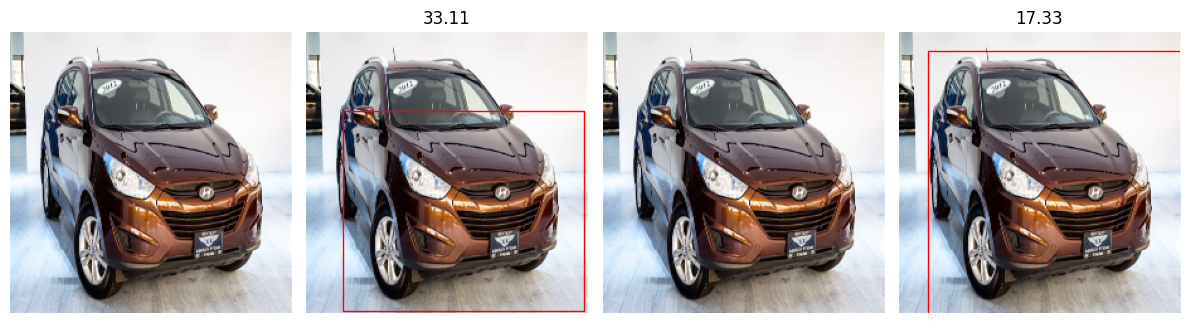

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
0.19999408721923828  seconds to predict bounding boxes.


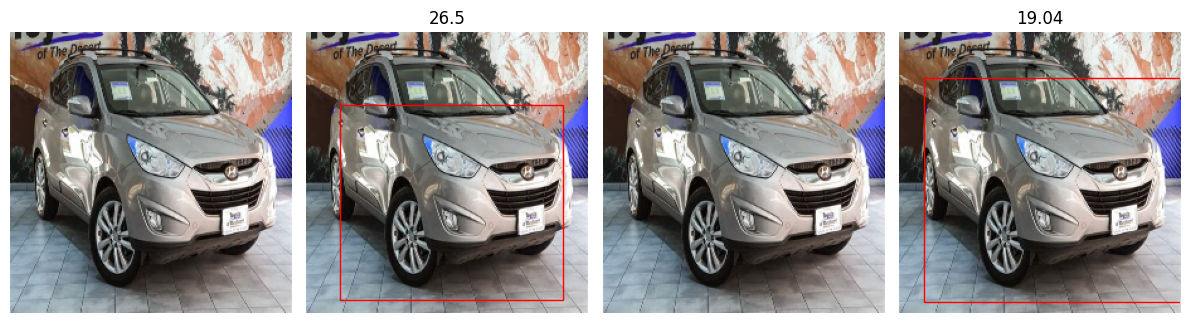

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
0.2062852382659912  seconds to predict bounding boxes.


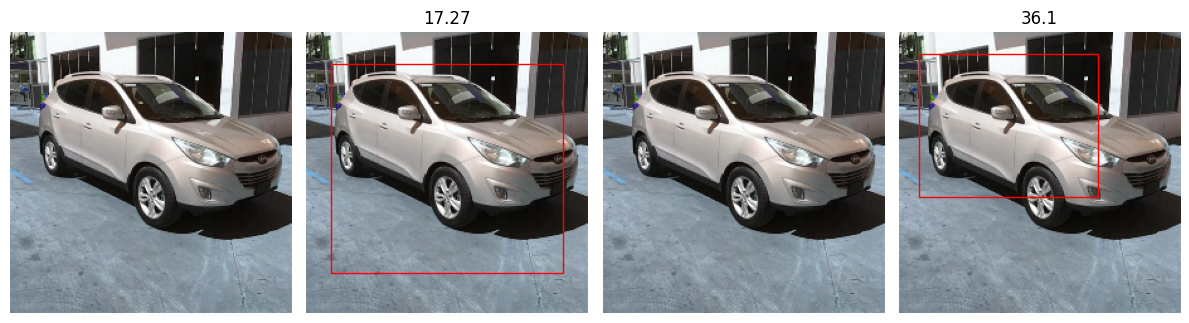

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
0.19950342178344727  seconds to predict bounding boxes.


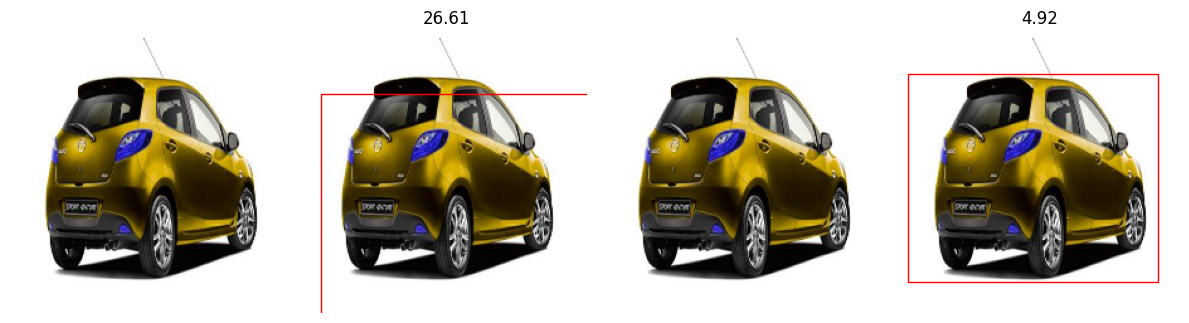

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
0.21143317222595215  seconds to predict bounding boxes.


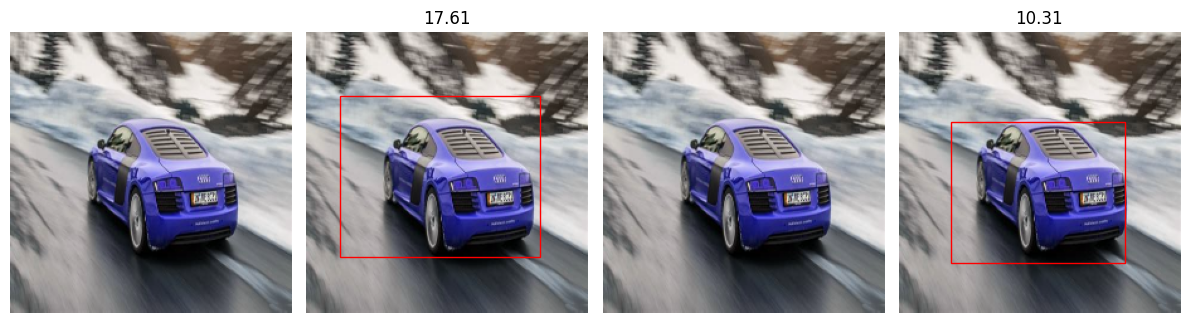

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
0.19960522651672363  seconds to predict bounding boxes.


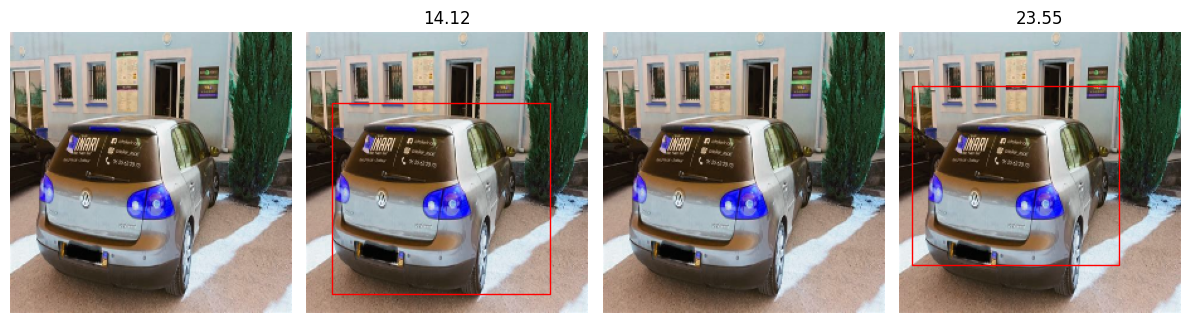

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
0.20290613174438477  seconds to predict bounding boxes.


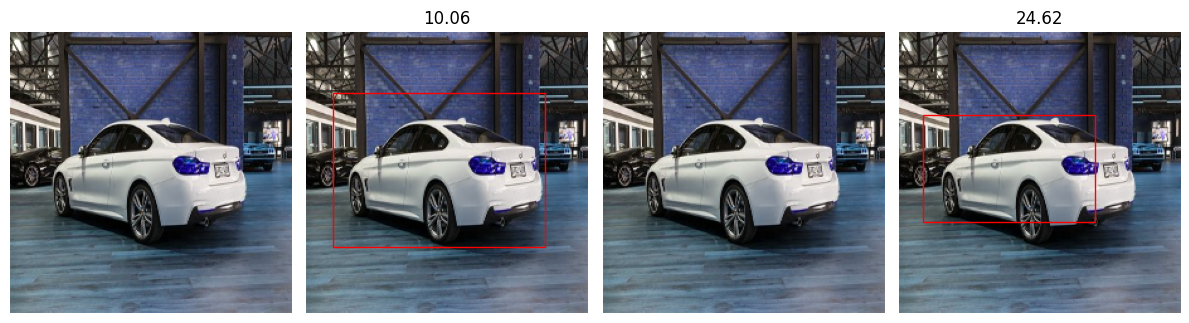

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
0.20081686973571777  seconds to predict bounding boxes.


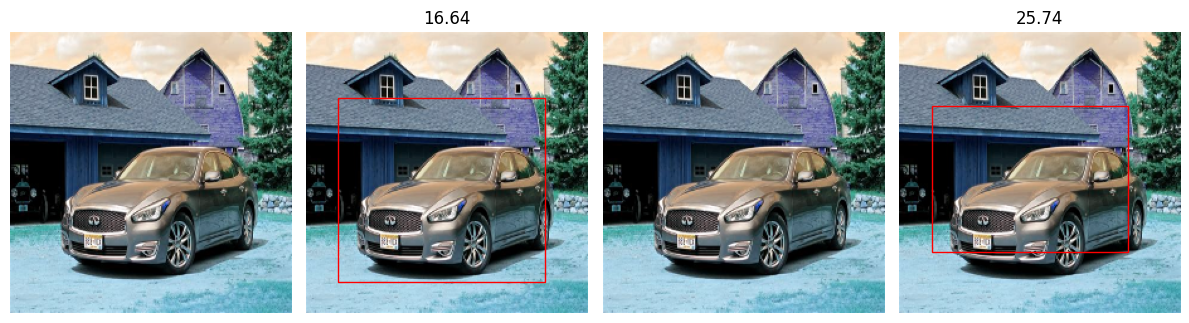

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
0.21268153190612793  seconds to predict bounding boxes.


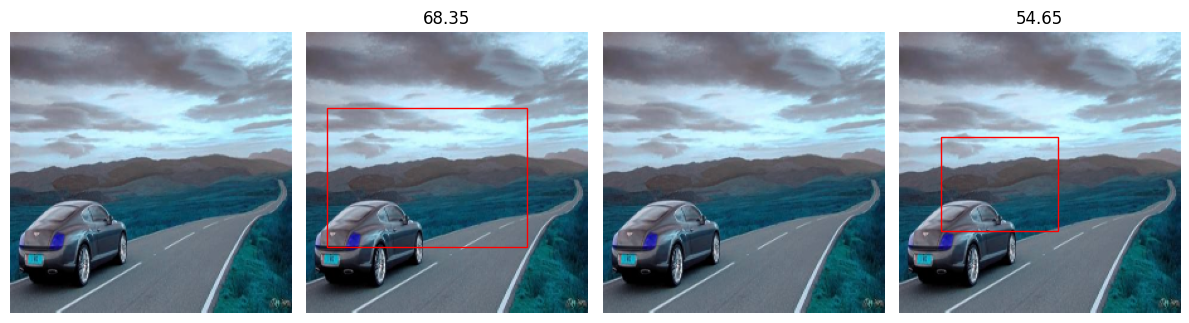

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
0.2003016471862793  seconds to predict bounding boxes.


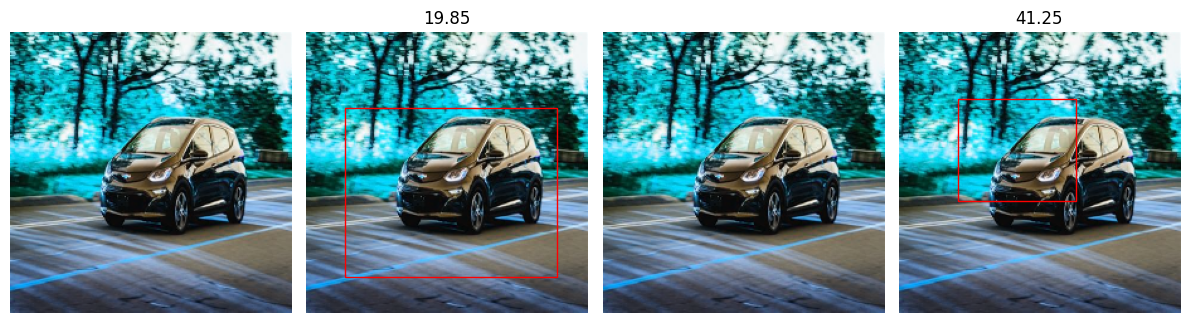

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
0.2124009132385254  seconds to predict bounding boxes.


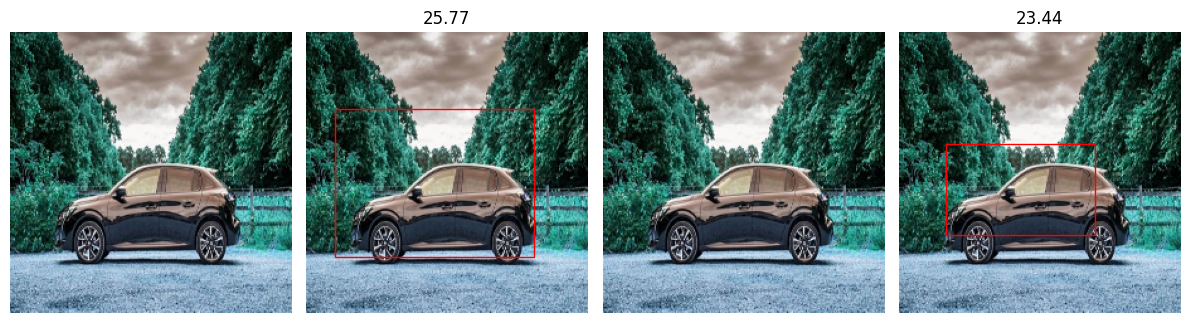

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
0.20175671577453613  seconds to predict bounding boxes.


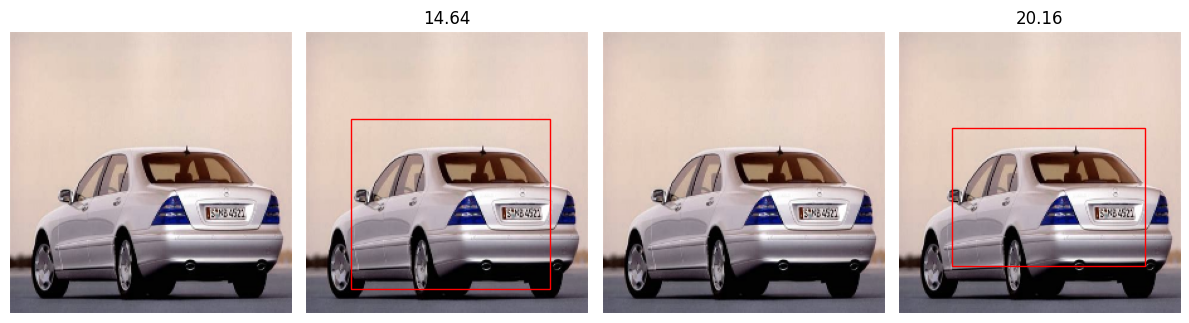

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
0.2339789867401123  seconds to predict bounding boxes.


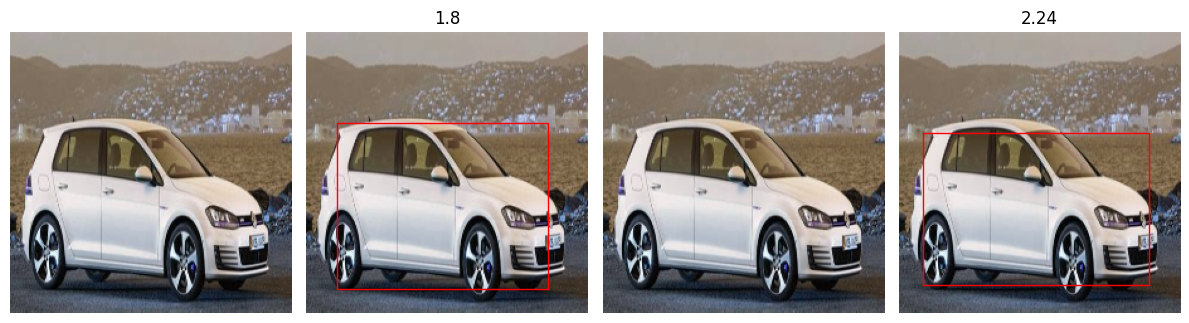

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
0.2225511074066162  seconds to predict bounding boxes.


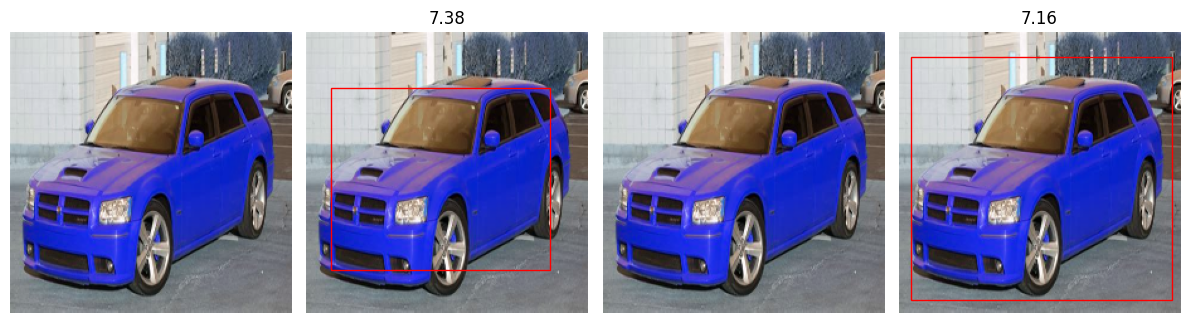

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
0.20243024826049805  seconds to predict bounding boxes.


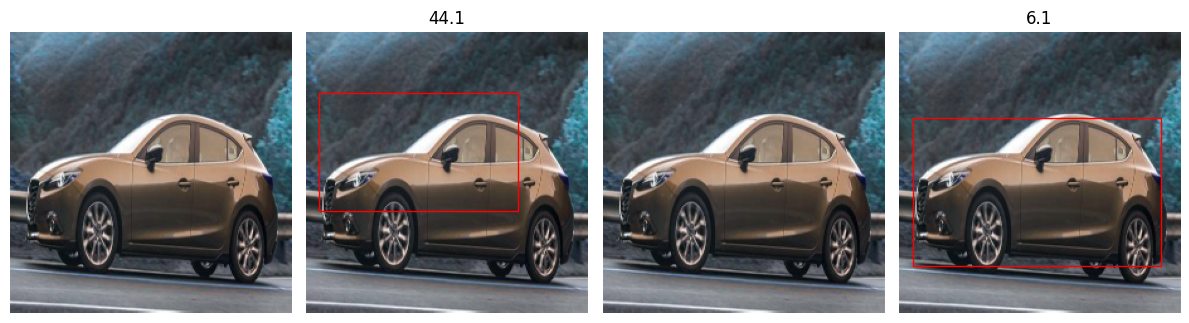

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
0.42651987075805664  seconds to predict bounding boxes.


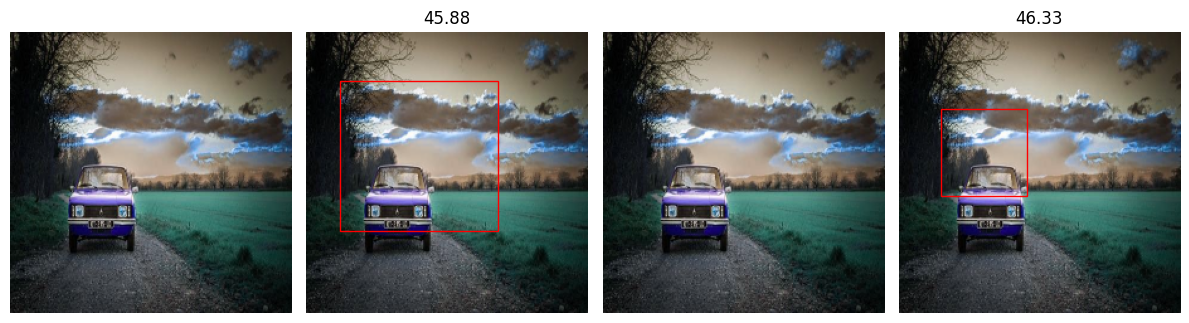

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
0.20115065574645996  seconds to predict bounding boxes.


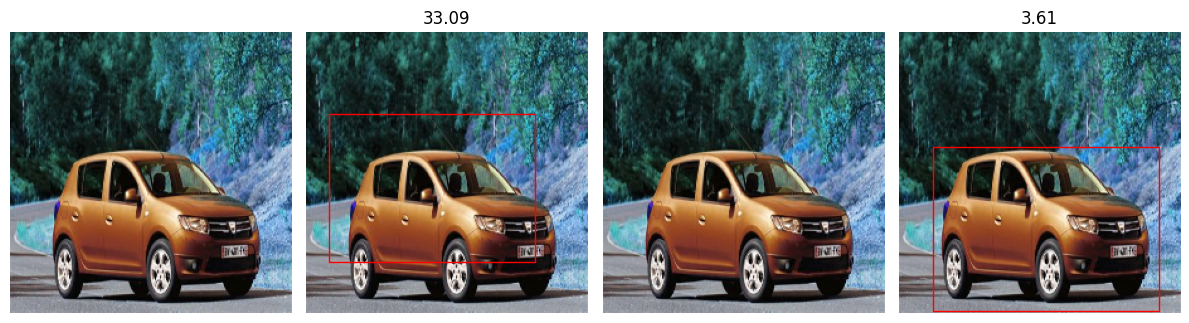

Average distance of Sequential:  22.223103448275864
Average distance of VGG:  20.812068965517245


In [40]:
# Calculates the distance between two rectangles defined by their 4 corner points.
def rectangle_distance(rect1, rect2):
    # Calculate the midpoint of each rectangle
    rect1_midpoint = ((rect1[0] + rect1[2]) / 2, (rect1[1] + rect1[3]) / 2)
    rect2_midpoint = ((rect2[0] + rect2[2]) / 2, (rect2[1] + rect2[3]) / 2)

    # Calculate the distance between the midpoints
    distance = math.sqrt((rect1_midpoint[0] - rect2_midpoint[0])**2 + (rect1_midpoint[1] - rect2_midpoint[1])**2)

    return round(distance, 2)

# Display one image without and one image with bounding boxes.
def display_images(path1, x1, y1, x2, y2, distance1, path2, x3, y3, x4, y4, distance2):
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))
    
    # Image 1 without bounding box
    ax[0].imshow(path1)
    ax[0].axis("off")
    
    # Image 1 with bounding box
    ax[1].imshow(path1)
    ax[1].set_title(distance1)
    rect1 = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
    ax[1].add_patch(rect1)
    ax[1].axis("off")
    
    # Image 2 without bounding box
    ax[2].imshow(path2)
    ax[2].axis("off")
    
    # Image 2 with bounding box
    ax[3].imshow(path2)
    ax[3].set_title(distance2)
    rect2 = patches.Rectangle((x3, y3), x4-x3, y4-y3, linewidth=1, edgecolor='r', facecolor='none')
    ax[3].add_patch(rect2)
    ax[3].axis("off")
    
    plt.tight_layout()
    plt.show()


totalDistance1 = 0
totalDistance2 = 0

# Loop through the image filenames and process each image
for index in range(len(X_test)):
    start = time.time()
    image = np.expand_dims(X_test[index], axis=0)
    preds1 = model1.predict(image)
    preds2 = model2.predict(image)
    print(time.time() - start, " seconds to predict bounding boxes.")
    x1, y1, x2, y2 = preds1.astype('int')[0]
    x3, y3, x4, y4 = preds2.astype('int')[0]
    distance1 = rectangle_distance(Y_test[index], (x1, y1, x2, y2))
    totalDistance1 += distance1
    distance2 = rectangle_distance(Y_test[index], (x3, y3, x4, y4))
    totalDistance2 += distance2
    display_images(X_test[index], x1, y1, x2, y2, distance1, X_test[index], x3, y3, x4, y4, distance2)

print("Average distance of Sequential: ", totalDistance1 / len(X_test))
print("Average distance of VGG: ", totalDistance2 / len(X_test))


# Experimenten
Om te testen of het model ook werkt op foto's die niet in de dataset staan heb ik een aantal experimenten bedacht.



### Experiment 1: Meerdere auto's in een foto.
In dit experiment ga ik kijken wat er gebeurd als er meerdere auto's in een afbeelding staat.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
0.2247457504272461  seconds to predict bounding boxes.


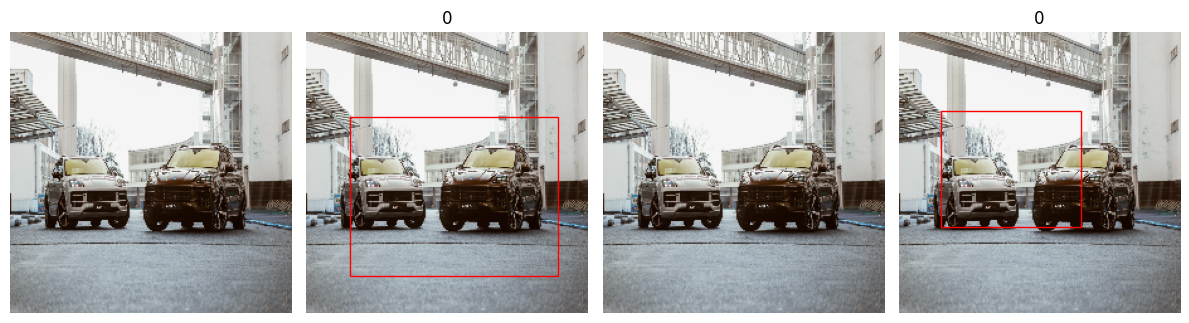

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
0.2042231559753418  seconds to predict bounding boxes.


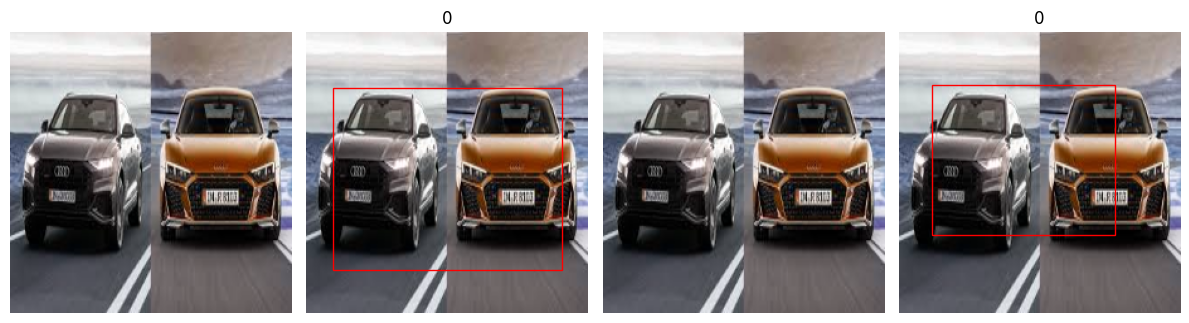

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
0.20205092430114746  seconds to predict bounding boxes.


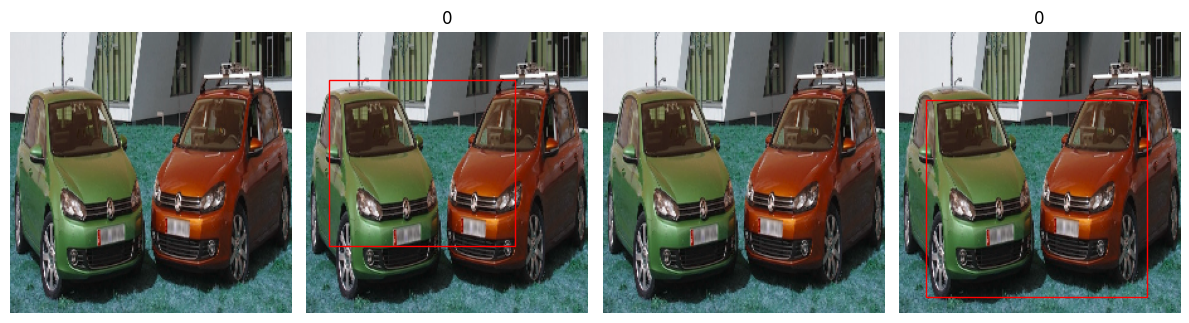

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
0.20361113548278809  seconds to predict bounding boxes.


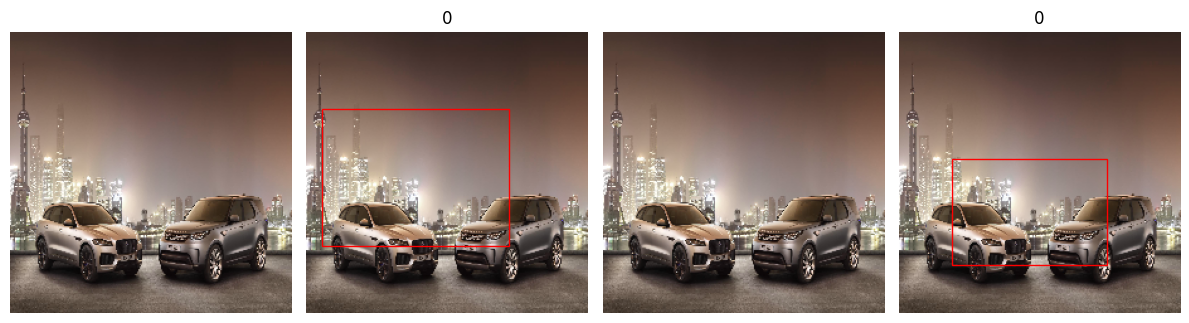

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
0.2042856216430664  seconds to predict bounding boxes.


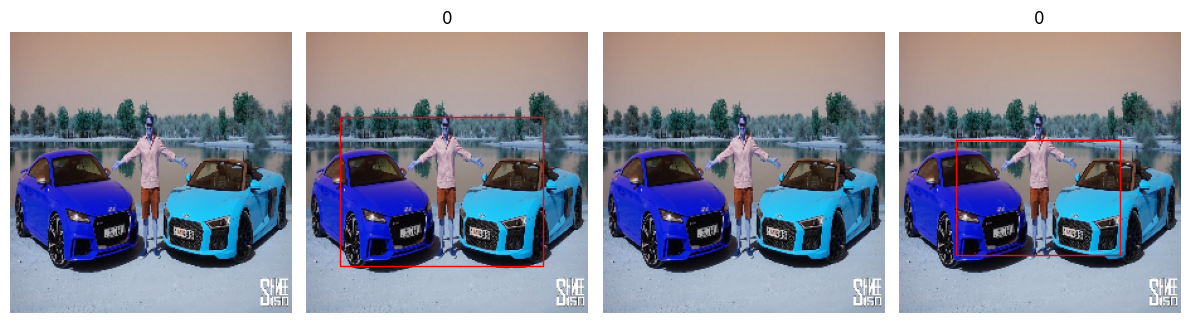

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
0.21773624420166016  seconds to predict bounding boxes.


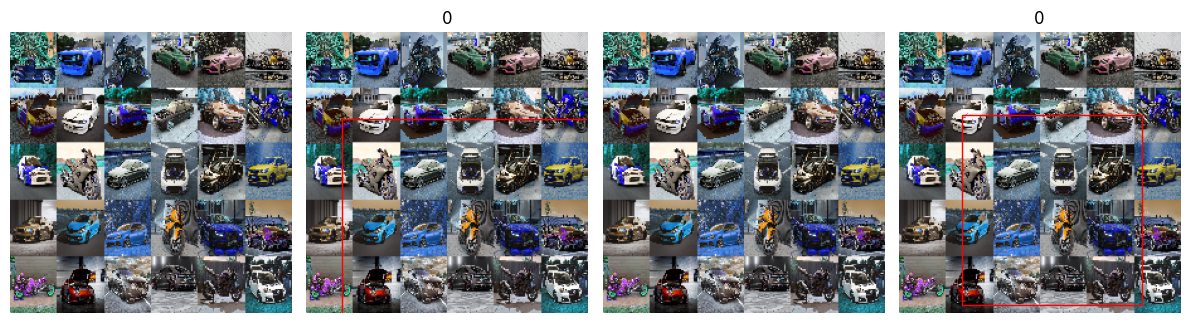

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
0.20434951782226562  seconds to predict bounding boxes.


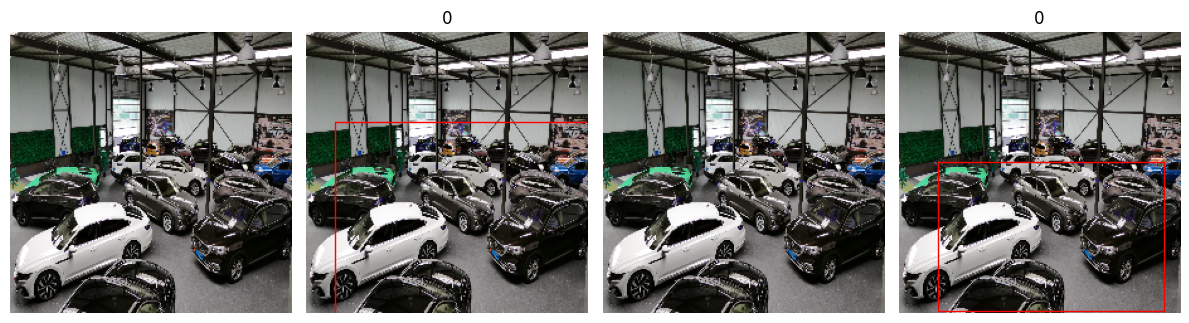

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
0.20319366455078125  seconds to predict bounding boxes.


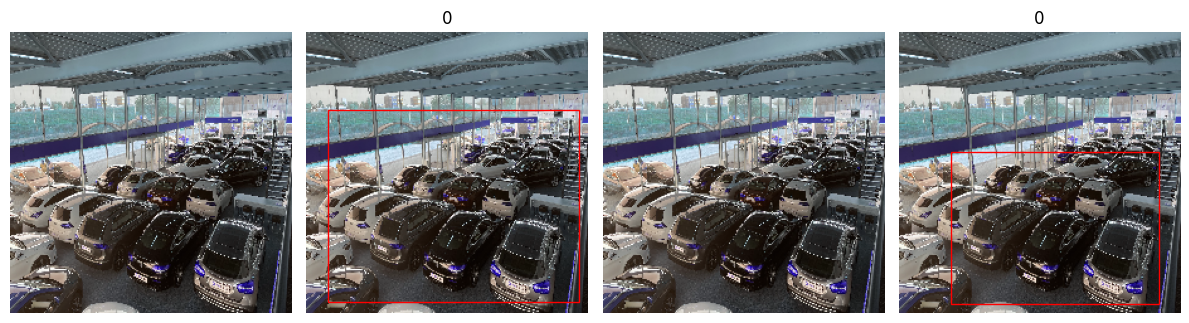

In [41]:
# Loop through the image filenames and process each image
for index in range(len(X_multi)):
    start = time.time()
    image = np.expand_dims(X_multi[index], axis=0)
    preds1 = model1.predict(image)
    preds2 = model2.predict(image)
    print(time.time() - start, " seconds to predict bounding boxes.")
    x1, y1, x2, y2 = preds1.astype('int')[0]
    x3, y3, x4, y4 = preds2.astype('int')[0]
    display_images(X_multi[index], x1, y1, x2, y2, 0, X_multi[index], x3, y3, x4, y4, 0)
    

### Experiment 2: Auto's van bovenaf.
In dit experiment ga ik kijken hoe goed de auto's herkend kunnen worden door het model als de auto's van bovenaf op de afbeelding staan.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
0.20714378356933594  seconds to predict bounding boxes.


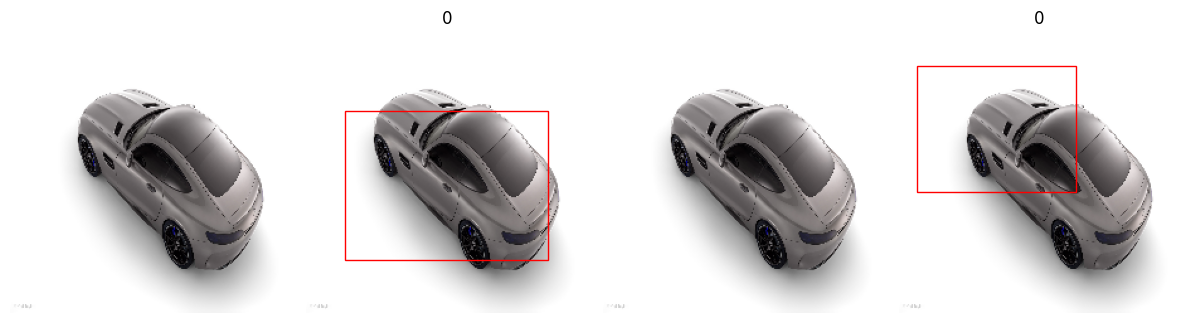

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
0.21937894821166992  seconds to predict bounding boxes.


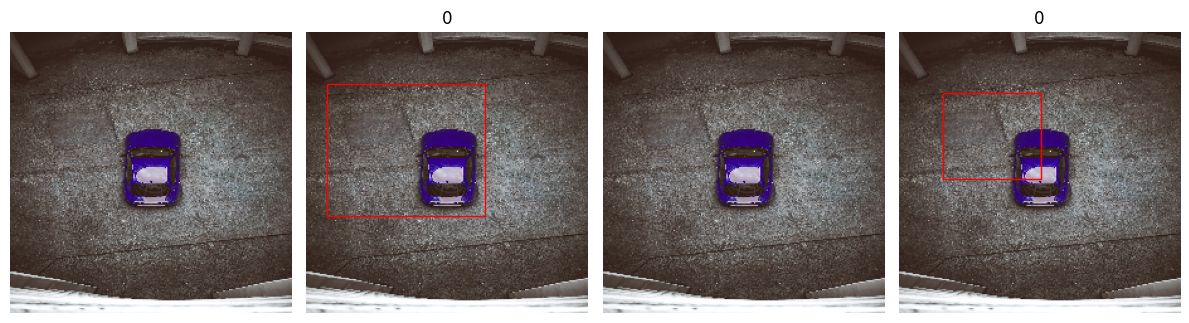

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
0.20219063758850098  seconds to predict bounding boxes.


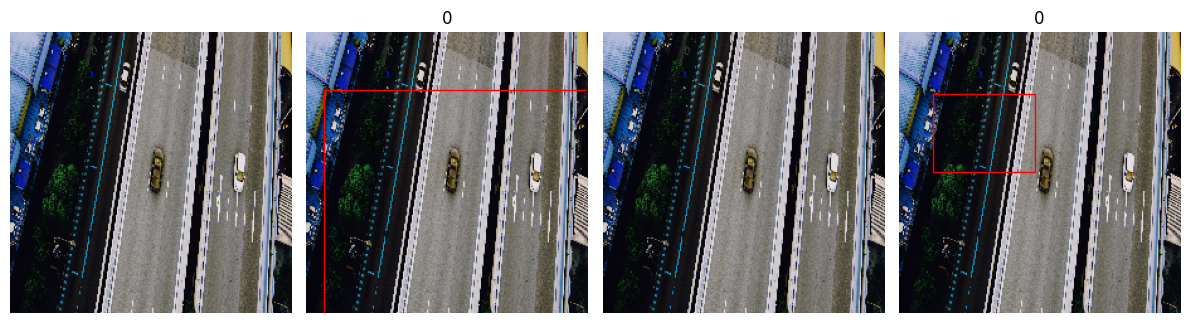

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
0.2064225673675537  seconds to predict bounding boxes.


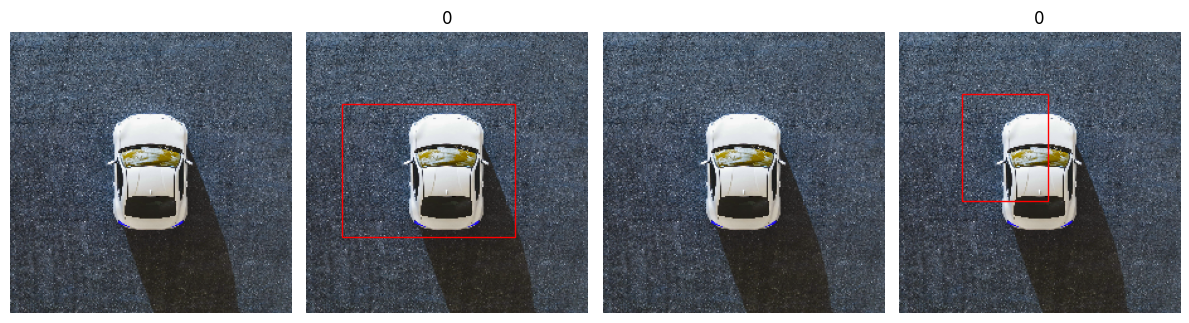

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
0.20383286476135254  seconds to predict bounding boxes.


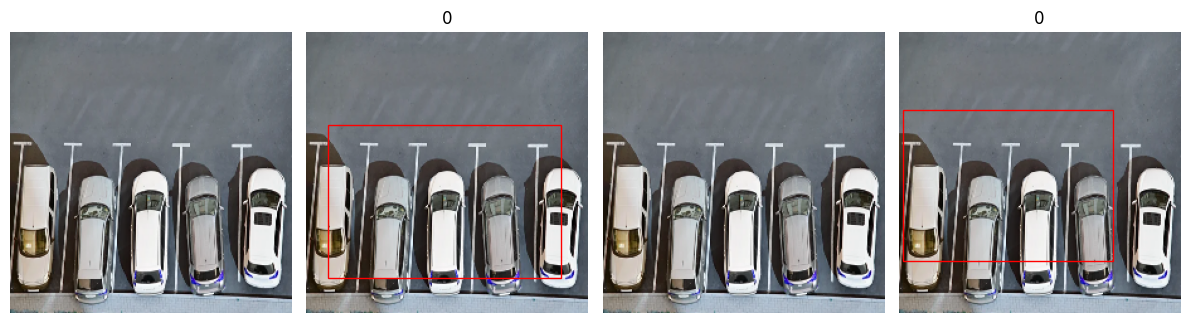

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
0.23227477073669434  seconds to predict bounding boxes.


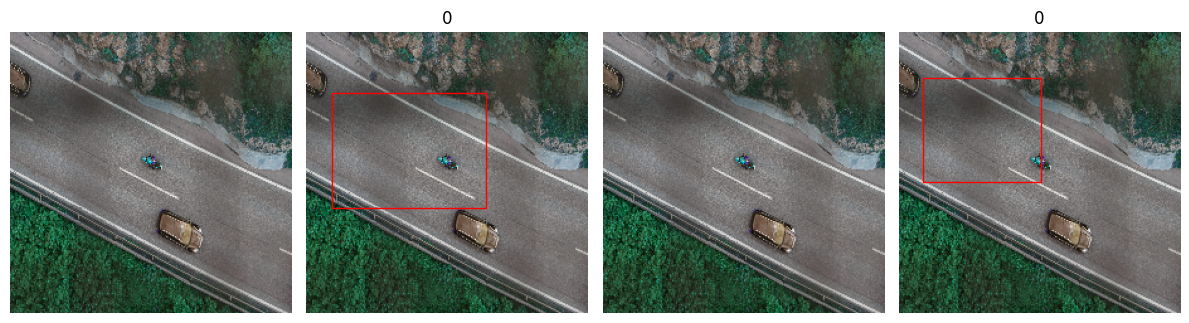

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
0.42255687713623047  seconds to predict bounding boxes.


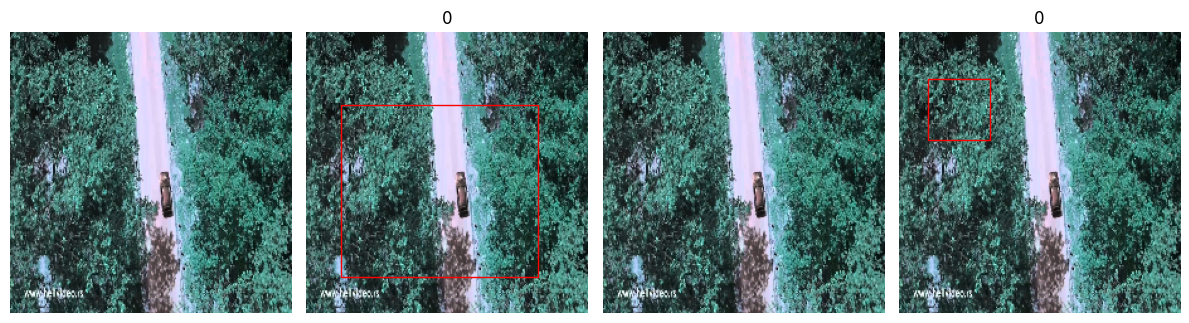

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
0.2076568603515625  seconds to predict bounding boxes.


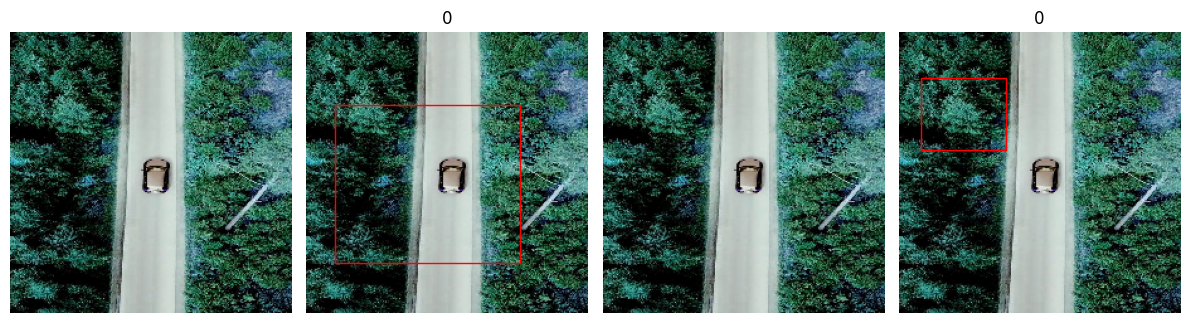

In [42]:
# Loop through the image filenames and process each image
for index in range(len(X_above)):
    start = time.time()
    image = np.expand_dims(X_above[index], axis=0)
    preds1 = model1.predict(image)
    preds2 = model2.predict(image)
    print(time.time() - start, " seconds to predict bounding boxes.")
    x1, y1, x2, y2 = preds1.astype('int')[0]
    x3, y3, x4, y4 = preds2.astype('int')[0]
    display_images(X_above[index], x1, y1, x2, y2, 0, X_above[index], x3, y3, x4, y4, 0)
    